In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

from typing import Sequence, Callable, Optional, Dict, Any
from typing import List

from MMNN import SinTUActivation,Train_jax_model, MMNN

import jax
import jax.numpy as jnp
import jax.random as jrandom
import flax.linen as nn
import optax
import diffrax

import matplotlib.pyplot as plt
# plt.style.use('figures/images_style.mplstyle')
import numpy as np
import platform
# XLA_PYTHON_CLIENT_ALLOCATOR=platform.system()  # Ensure JAX uses the system allocator


# 1D Test

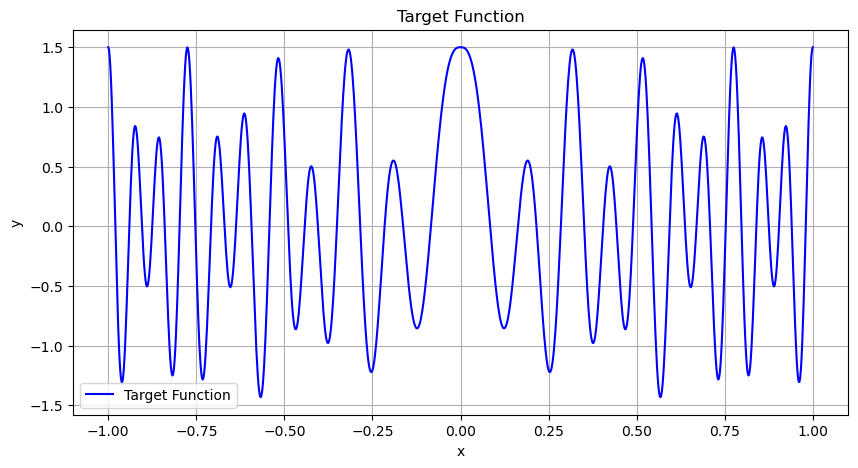

In [2]:
y = lambda x: np.cos(20*np.pi*np.abs(x)**(1.4))+0.5*np.cos(12*np.pi*np.abs(x)**(1.6))

# Input data

x = np.linspace(-1, 1, 1000)
x = x.reshape(-1, 1)  # Reshape to 2D array

# Target data

y_data = y(x)

# Plot data

plt.figure(figsize=(10, 5))
plt.plot(x, y_data, label='Target Function', color='blue')
plt.title('Target Function')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()


In [3]:
# Configuration using ranks and widths
ranks = [1]+ [18]*2 + [ 1]     # 
widths = [356]*3      # 

print("Network architecture:")
print(f"Ranks (dimensions): {ranks}")
print(f"Widths (hidden layer sizes): {widths}")

# Create model
model = MMNN(
    ranks=ranks,
    widths=widths,
    activation=SinTUActivation(),
    ResNet = False
)

scheduler = optax.exponential_decay(
    init_value=0.001,  # Initial learning rate
    transition_steps=100,  # Number of steps before decay
    decay_rate=0.96,  # Decay rate
    staircase=True  # Use staircase decay
)

train_model = Train_jax_model(
    model=model,
    input_data=x,
    target_data=y_data,
    optimizer='adam',
    loss_fn='mse',
    learning_rate=scheduler,
    num_epochs=5000,
    batch_size=500,
    random_seed=42,
    device=2
)

Network architecture:
Ranks (dimensions): [1, 18, 18, 1]
Widths (hidden layer sizes): [356, 356, 356]


In [5]:
params,epochs_dict = train_model.training_loop(print_every=1000)

KeyboardInterrupt: 

# 2D Test

In [17]:
def func(x):
    def cart2pol(x, y):
        '''Convert Cartesian coordinates to polar coordinates.'''
        r = jnp.sqrt(x**2 + y**2)
        theta = jnp.arctan2(y, x)
        return(r, theta)
    r, theta = cart2pol(x[:,0], x[:,1])
    m=jnp.pi**2
    r1 = 0.5+ 0.2*jnp.cos(m*theta**2)
    z1 = 0.5 - 5*(r-r1)
    def g(z):        
        z = jnp.maximum(z, 0)
        z = jnp.minimum(z, 1)
        return(z)
    y = g(z1)
    return y


In [ ]:
# device = jax.devices("gpu")[2] if jax.devices("gpu") else jax.devices("cpu")[0]




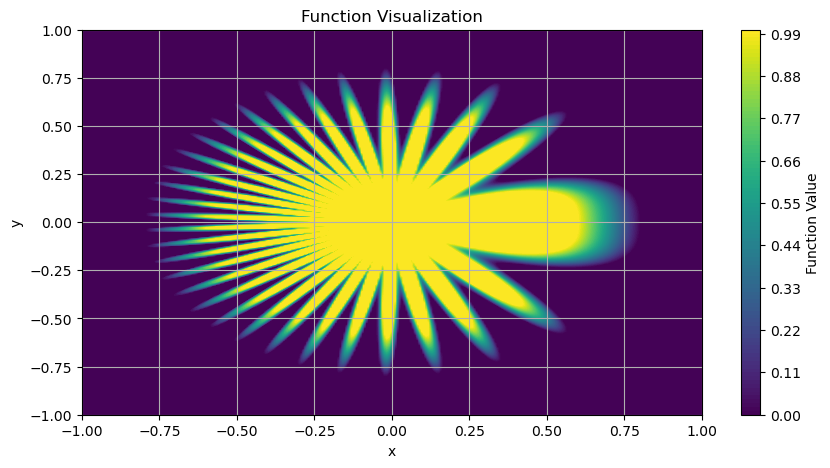

In [41]:

# Plot function
x_test = jnp.linspace(-1, 1, 300)
# x_test = jax.device_put(x_test, device)
y_test = jnp.linspace(-1, 1, 300)
# y_test = jax.device_put(y_test, device)
X_test, Y_test = jnp.meshgrid(x_test, y_test)
data = jnp.column_stack((X_test.ravel(), Y_test.ravel()))
Z_test = func(data)
Z_test = Z_test.reshape(X_test.shape)
output = Z_test.reshape(-1, 1)

plt.figure(figsize=(10, 5))
plt.contourf(X_test, Y_test, Z_test, levels=100, cmap='viridis')
plt.colorbar(label='Function Value')
plt.title('Function Visualization')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()  

In [42]:
# Configuration using ranks and widths
ranks = [2]+ [18]*5 + [ 1]     # 
widths = [356]*6      # 

print("Network architecture:")
print(f"Ranks (dimensions): {ranks}")
print(f"Widths (hidden layer sizes): {widths}")

# Create model
model = MMNN(
    ranks=ranks,
    widths=widths,
    activation=SinTUActivation(),
    ResNet = True
)

scheduler = optax.exponential_decay(
    init_value=0.001,  # Initial learning rate
    transition_steps=100,  # Number of steps before decay
    decay_rate=0.96,  # Decay rate
    staircase=True  # Use staircase decay
)



Network architecture:
Ranks (dimensions): [2, 18, 18, 18, 18, 18, 1]
Widths (hidden layer sizes): [356, 356, 356, 356, 356, 356]


In [43]:
train_model = Train_jax_model(
    model=model,
    input_data=data,
    target_data=output,
    optimizer='adam',
    loss_fn='mse',
    learning_rate=scheduler,
    num_epochs=5000,
    batch_size=500,
    random_seed=42,
    device=2
)

In [51]:
params,epochs_dict = train_model.training_loop(print_every=jnp.inf)

In [55]:

# Plot function
x_test = jnp.linspace(-1, 1, 500)
# x_test = jax.device_put(x_test, device)
y_test = jnp.linspace(-1, 1, 500)
# y_test = jax.device_put(y_test, device)
X_test, Y_test = jnp.meshgrid(x_test, y_test)
data_test = jnp.column_stack((X_test.ravel(), Y_test.ravel()))
Z_test = func(data_test)
output_test = Z_test.reshape(X_test.shape)




In [56]:
model_output = model.apply(params, data_test).reshape(X_test.shape)



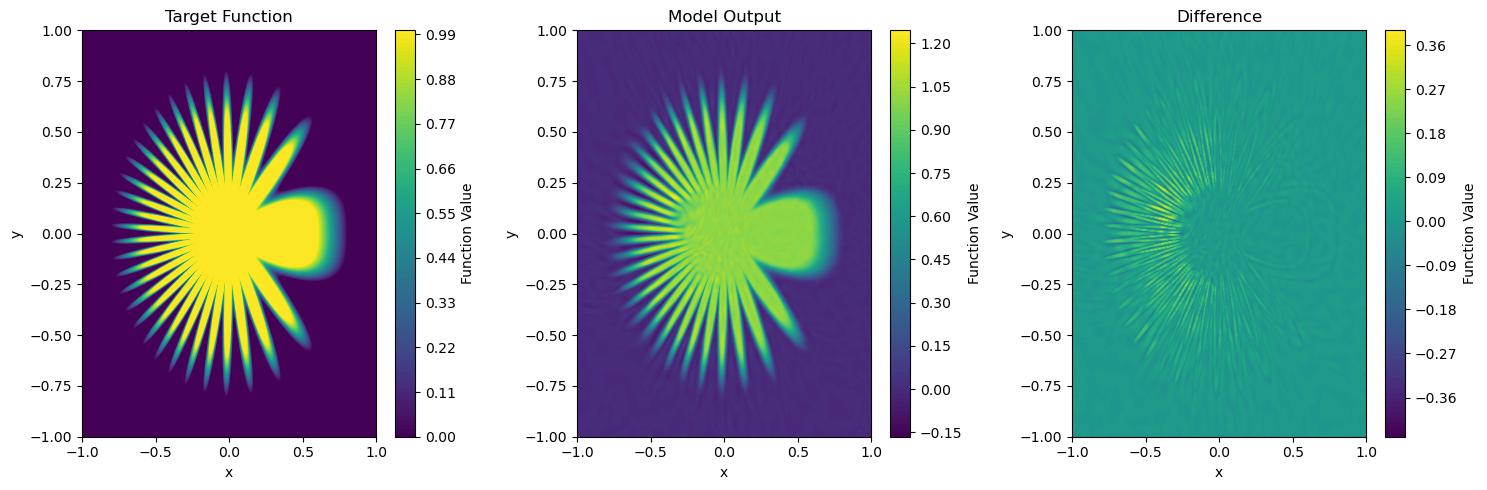

In [57]:
fig,ax = plt.subplots(1,3,figsize=(15, 5))

# ax[0].contourf(X_test, Y_test, output_test, levels=100, cmap='viridis')
plt.colorbar(ax[0].contourf(X_test, Y_test, output_test, levels=100, cmap='viridis'), ax=ax[0], label='Function Value')
ax[0].set_title('Target Function')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')  

# ax[1].contourf(X_test, Y_test, model_output, levels=100, cmap='viridis')
plt.colorbar(ax[1].contourf(X_test, Y_test, model_output, levels=100, cmap='viridis'), ax=ax[1], label='Function Value')
ax[1].set_title('Model Output')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')   
# ax[2].contourf(X_test, Y_test, output_test-model_output, levels=100, cmap='viridis')
plt.colorbar(ax[2].contourf(X_test, Y_test, output_test-model_output, levels=100, cmap='viridis'), ax=ax[2], label='Function Value')
ax[2].set_title('Difference')
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')

plt.tight_layout()
plt.show()